In [1]:
### This plot plot the pearson correlation between replicates 
import pandas as pd
from os.path import join
import seaborn as sns
from itertools import combinations, product
import pickle

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc


import scipy.stats as stats 
sns.set_theme(style="white", font_scale=1.2,palette='viridis')
font = {'weight' : 'bold', 'family':'Nimbus Sans'}
rc('font', **font) 

### 1. Read Count distribution

In [35]:
def plot_rd_dist(cell_line, library, 
                 input_path='../data/sequencing/Library/read_count', 
                 output_path='./Figures/read_count_dist', 
                 categ_col='sgRNA category'):
    df_ = pd.read_csv(join(input_path, f'{cell_line}_DN1_{library}_df.csv'), index_col=0)
    df_[categ_col] = [i.split('_')[0] for i in df_.index]
    
    name = f'{cell_line[0]}{library[0]}'
    sel_df = df_[[f'count_{name}1_DN1', f'count_{name}2_DN1', 'sgRNA category']]
    
    axes = sns.pairplot(sel_df,hue='sgRNA category',kind='hist')
    
    for ax in axes.axes.flat:
        ax.set_xlabel(ax.get_xlabel(), fontweight='bold')
        ax.set_ylabel(ax.get_ylabel(), fontweight='bold')

    axes.fig.suptitle(f'{cell_line} {library} Read Count Distribution', y = 1.05,fontweight='bold')
    plt.savefig(join(output_path, f'{cell_line}_{library}_DN1.png'), transparent=True)
    plt.show()   

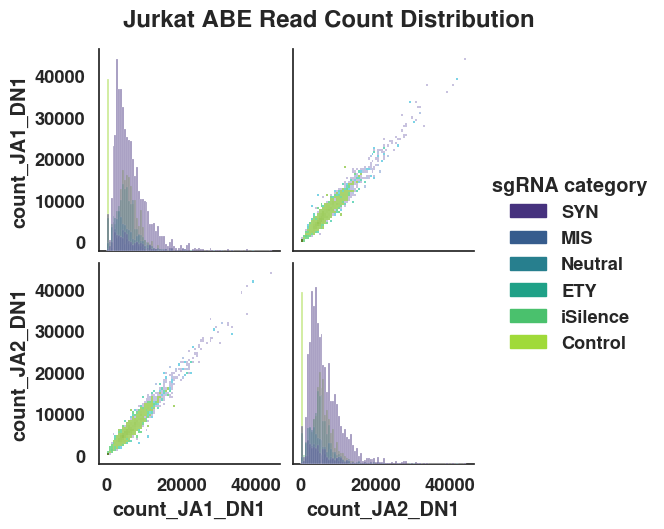

In [ ]:
# plot_rd_dist('Jurkat','ABE')
# plot_rd_dist('Jurkat','CBE')
# plot_rd_dist('K562','CBE')
# plot_rd_dist('K562','ABE')

### 2. Replicate correlation （all）

In [61]:
def calc_L2FC(df, lib1, lib2):
    l2fc1 = np.log2((df[lib1] / df[lib1].sum() * 1000000) + 1)
    l2fc2 = np.log2((df[lib2] / df[lib2].sum() * 1000000) + 1)
    l2fc = l2fc2 - l2fc1
    return l2fc

def plot_corr(ax, df_, label_, cell_line = None, library=None, editor=None, baseline=None, endpoint=None):
    label_l = [i for i in df_.index if i.startswith(f'{label_}')]
    df_ = df_.loc[label_l, :]
    abbv = cell_line[0] + library[0]
    df_lfc = pd.DataFrame({
        'rep1': calc_L2FC(df_, f'count_{abbv}1_{baseline}', f'count_{abbv}1_{endpoint}_{editor}'),
        'rep2': calc_L2FC(df_, f'count_{abbv}2_{baseline}', f'count_{abbv}2_{endpoint}_{editor}')
    })
    corr = df_lfc['rep1'].corr(df_lfc['rep2'])

    sns.scatterplot(data=df_lfc, x="rep1", y="rep2", alpha=0.5, ax=ax)
    
    ax.set_title(f'{label_} {editor} L2FC', fontweight='bold')
    ax.text(-7.5, -8, f'Pearson r = {round(corr, 2)}', fontsize=10)
    ax.set_xlim([-8.5, 3.5])
    ax.set_ylim([-8.5, 3.5])
    ax.set_xlabel('Replicate 1', fontweight='bold')
    ax.set_ylabel('Replicate 2', fontweight='bold')
    ax.plot([-8.5, 3.5], [-8.5, 3.5], ls='--', color='gray', alpha=0.5)
    ax.set_aspect('equal')
    return ax

def plot_correlation(baseline='DN1', endpoint=None, 
                     library=None, editor=None,
                     cell_line=None,
                     input_path='../data/sequencing/Library/filtered_read_count',
                     output_path='./Figures/rep_L2FC_corr'):
    
    df = pd.read_csv(join(input_path, f'{cell_line}_{library}_{baseline}_{endpoint}.csv'), index_col=0)
    label_list = list(set([i.split('_')[0] for i in df.index]))  # Ensure unique labels
    print(label_list)
    
    fig, ax = plt.subplots(1, len(label_list), figsize=(3 * len(label_list), 3))
    for i, label in enumerate(label_list):
        plot_corr(ax[i],df, label, cell_line = cell_line, library= library, editor= editor, baseline= baseline, endpoint=endpoint )
        
    fig.suptitle(f'{cell_line} {library} {editor} L2FC Replicate Correlation',fontweight='bold')

    
    plt.tight_layout()
    plt.savefig(join(output_path, f'{cell_line}_{library}_{editor}_{baseline}_{endpoint}.png'), transparent=True)
    plt.show()
    return fig, ax

['iSilence', 'MIS', 'Control', 'SYN', 'Neutral', 'ETY']


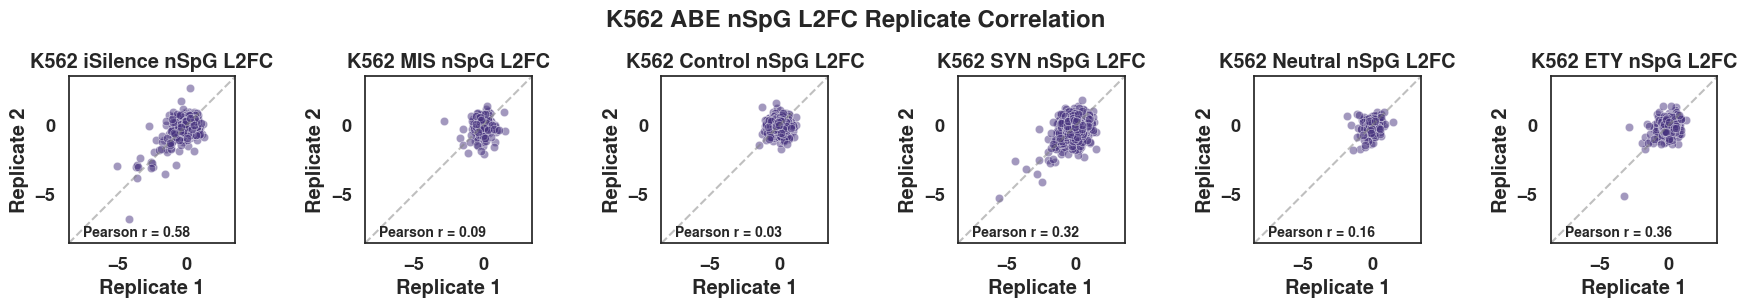

(<Figure size 1800x300 with 6 Axes>,
 array([<AxesSubplot:title={'center':'K562 iSilence nSpG L2FC'}, xlabel='Replicate 1', ylabel='Replicate 2'>,
        <AxesSubplot:title={'center':'K562 MIS nSpG L2FC'}, xlabel='Replicate 1', ylabel='Replicate 2'>,
        <AxesSubplot:title={'center':'K562 Control nSpG L2FC'}, xlabel='Replicate 1', ylabel='Replicate 2'>,
        <AxesSubplot:title={'center':'K562 SYN nSpG L2FC'}, xlabel='Replicate 1', ylabel='Replicate 2'>,
        <AxesSubplot:title={'center':'K562 Neutral nSpG L2FC'}, xlabel='Replicate 1', ylabel='Replicate 2'>,
        <AxesSubplot:title={'center':'K562 ETY nSpG L2FC'}, xlabel='Replicate 1', ylabel='Replicate 2'>],
       dtype=object))

In [71]:
plot_correlation(baseline='DN1', endpoint='D0', 
         library='ABE', editor='nSpG',
         cell_line='K562')

### 3. Volcano(all)

In [68]:
def plot_volcano(ax, df_, cell_line, library, editor, label, highlight_groups = None, highlight_colors = None, annotate = True):
    # Plot all points
    colors = np.where(df_['-log10padj'] > -np.log10(0.05), 'blue', 'grey')
    ax.scatter(df_['log2FoldChange'], df_['-log10padj'], c=colors, alpha=0.5, s=70)
    if highlight_groups:
        for (highlight, hl_color) in zip(highlight_groups, highlight_colors):
            df_sub = df_.loc[highlight,:]
            ax.scatter(df_sub['log2FoldChange'], df_sub['-log10padj'], c=hl_color, alpha=1, s=300, marker = '*')

    # Draw a horizontal line at y=2
    ax.axhline(y=-np.log10(0.05), color='grey', linestyle='--')

    # Count the number of red points
    red_count = (df_['-log10padj'] > -np.log10(0.05)).sum()
    total_count = len(df_)
    annotation_text = f'Hit Rate: {round(red_count / total_count * 100, 2)}% ({red_count}/{total_count})'
    
    if annotate:
        # Annotate the count
        ax.annotate(annotation_text, xy=(0.95, 0.95), xycoords='axes fraction', fontsize=12,
                    horizontalalignment='right', verticalalignment='top', 
                    bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))

    # Set labels and title
    ax.set_xlabel('log2 Fold Change', fontweight = 'bold')
    ax.set_ylabel('-log10 Adjusted P-value', fontweight = 'bold')
    ax.set_title(f'{label} {editor}', fontweight = 'bold')

    # Increase the font size of the tick labels
    ax.tick_params(axis='both', which='major', labelsize=12)
    return ax

def make_volcano_plot(cell_line = None, library = None, editor = None, baseline = None, endpoint = None,
                      input_path='../data/output/DESeq',
                      output_path='./Figures/volcano'):
    
    # Read data
    df = pd.read_csv(join(input_path, f'DESeq2_{cell_line}_{library}_{editor}_{endpoint}_{baseline}.csv'), index_col=0)
    
    # Extract unique labels
    label_list = list(set([i.split('_')[0] for i in df.index]))  # Ensure unique labels
    print(f"Labels found: {label_list}")
    
    # Create subplots
    fig, ax = plt.subplots(1, len(label_list), figsize=(4 * len(label_list), 4))
    if len(label_list) == 1:  # Handle single plot case
        ax = [ax]

    for i, label in enumerate(label_list):
        # Subset data for the current label
        list_label = [i for i in df.index if i.startswith(label)]
        df_ = df.loc[list_label, :]
        df_['-log10padj'] = -np.log10(df_['padj'])

        # Plot individual volcano plot
        plot_volcano(ax[i], df_, cell_line, library, editor, label)

    # Adjust layout
    fig.suptitle(f'{cell_line} {library} {editor} Volcano Plot',fontweight='bold')

    plt.tight_layout()
    
    # Save and display
    output_file = join(output_path, f'volcano_{cell_line}_{library}_{editor}_{baseline}_{endpoint}.png')
    plt.savefig(output_file, transparent=True)


Labels found: ['iSTOP', 'Neutral', 'ETY', 'STOP', 'Control', 'MIS', 'SYN', 'iSilence']


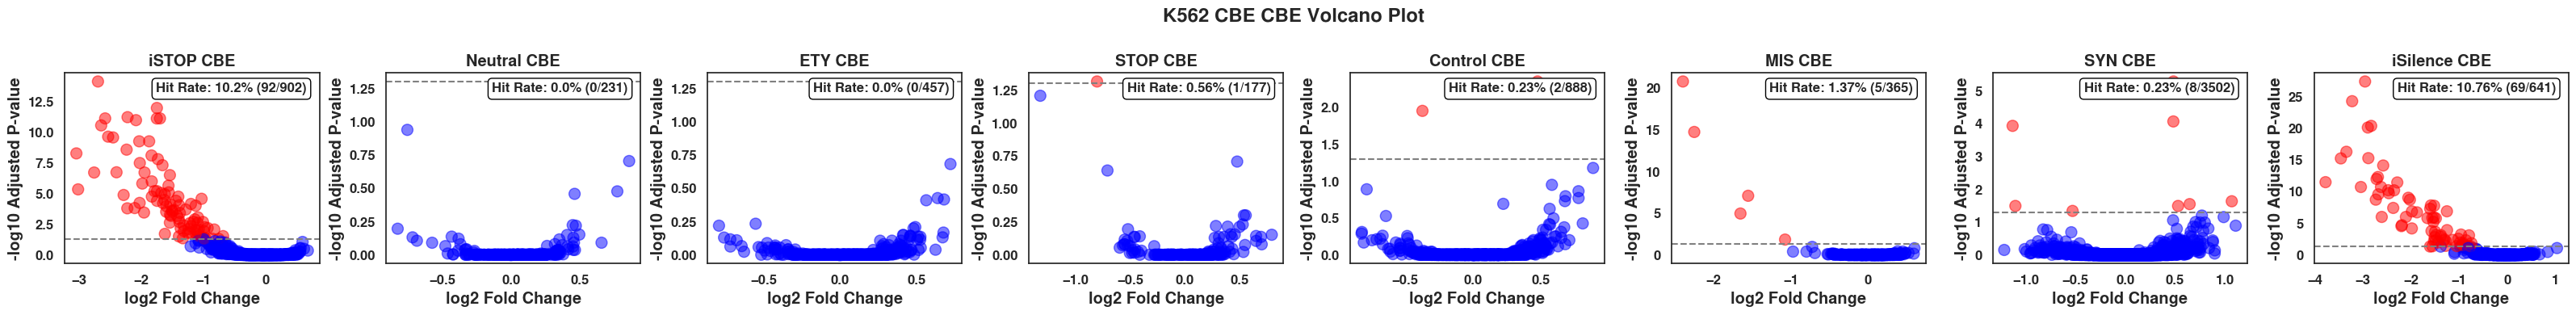

In [30]:
make_volcano_plot(cell_line = 'K562', library = 'CBE', editor = 'CBE', baseline = 'DN1', endpoint = 'D0',
                      input_path='../data/output/DESeq',
                      output_path='./Figures/volcano')

### 4. Replicate corr iSilence 

In [20]:
def calc_L2FC(df, lib1, lib2):
    l2fc1 = np.log2((df[lib1] / df[lib1].sum() * 1000000) + 1)
    l2fc2 = np.log2((df[lib2] / df[lib2].sum() * 1000000) + 1)
    l2fc = l2fc2 - l2fc1
    return l2fc

def plot_corr_ind(baseline='DN1', endpoint=None, 
                  library=None, editor=None,
                  cell_line=None, label=None,
                  input_path='../data/sequencing/Library/filtered_read_count',
                  output_path='./Figures/rep_L2FC_corr'):
    # Load data
    file_path = join(input_path, f'{cell_line}_{library}_{baseline}_{endpoint}.csv')   
    df = pd.read_csv(file_path, index_col=0)
    
    # Subset data for the specific label
    label_l = [i for i in df.index if i.startswith(f'{label}')]
    df_ = df.loc[label_l, :]
    abbv = cell_line[0] + library[0]  # Generate abbreviation dynamically
    
    # Calculate L2FC
    df_lfc = pd.DataFrame({
        'rep1': calc_L2FC(df_, f'count_{abbv}1_{baseline}', f'count_{abbv}1_{endpoint}_{editor}'),
        'rep2': calc_L2FC(df_, f'count_{abbv}2_{baseline}', f'count_{abbv}2_{endpoint}_{editor}')
    })
    corr = df_lfc['rep1'].corr(df_lfc['rep2'])
    
    # Create plot
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    sns.scatterplot(data=df_lfc, x="rep1", y="rep2", alpha=0.5, ax=ax, s = 100)
    
    # Customize plot
    ax.set_title(f'{cell_line} {library} {label} L2FC\n {endpoint} v.s. {baseline}', fontweight='bold')
    ax.text(-7.5, -8, f'Pearson r = {round(corr, 2)}')
    ax.set_xlim([-8.5, 3.5])
    ax.set_ylim([-8.5, 3.5])
    ax.set_xlabel('Replicate 1', fontweight='bold')
    ax.set_ylabel('Replicate 2', fontweight='bold')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.plot([-8.5, 3.5], [-8.5, 3.5], ls='--', color='gray', alpha=0.5)
    ax.set_aspect('equal')
    
    # Save figure
    output_file = join(output_path, f'corr_{cell_line}_{label}_{library}_{baseline}_{endpoint}.png')
    plt.savefig(output_file, transparent = True)
    plt.show()
    return ax

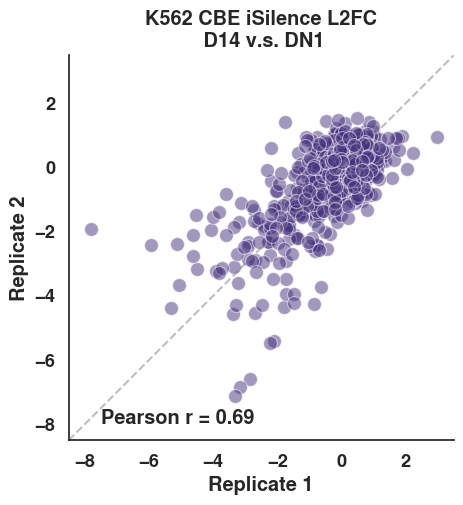

<AxesSubplot:title={'center':'K562 CBE iSilence L2FC\n D14 v.s. DN1'}, xlabel='Replicate 1', ylabel='Replicate 2'>

In [146]:
plot_corr_ind(
    baseline='DN1', endpoint='D14', 
    library='CBE', editor='CBE',
    label='iSilence', cell_line='K562'
)

### 5. Volcano plot individual iSilence

In [21]:
def make_volcano_ind(cell_line = None, label = None, library = None, editor = None, baseline = None, endpoint = None,
                      input_path='../data/output/DESeq',
                      output_path='./Figures/volcano'):
    df = pd.read_csv(join(input_path, f'DESeq2_{cell_line}_{library}_{editor}_{endpoint}_{baseline}.csv'), index_col=0)
    list_label = [i for i in df.index if i.startswith(label)]
    df_ = df.loc[list_label, :]
    df_['-log10padj'] = -np.log10(df_['padj'])
    fig, ax = plt.subplots(1,1, figsize = (5,5))
    # Plot individual volcano plot
    axs = plot_volcano(ax, df_, cell_line, library, editor, label)
    axs.spines['top'].set_visible(False)
    axs.spines['right'].set_visible(False)
    axs.set_title(f'{cell_line} {library} Volcano Plot\n {endpoint} v.s. {baseline}',fontweight='bold')
    # Adjust layout
    # fig.suptitle(f'{cell_line} {library} {editor} Volcano Plot\n {endpoint} v.s. {baseline}',fontweight='bold')
    plt.tight_layout()
    
    # Save and display
    output_file = join(output_path, f'volcano_{cell_line}_{label}_{library}_{editor}_{baseline}_{endpoint}.png')
    plt.savefig(output_file, transparent=True)


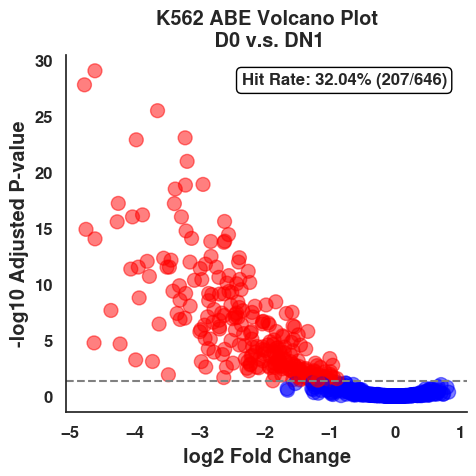

In [22]:
make_volcano_ind(cell_line = 'K562',label = 'iSilence', 
                 library = 'ABE', editor = 'ABE', 
                 baseline = 'DN1', endpoint = 'D0')

### 6. Correlation Coefficient plot individual for hits

In [2]:
import pickle

In [10]:
def make_hit_corr(cell1='K562', cell2='Jurkat', label=None, library=None, editor=None, baseline=None, endpoint=None,
                  highlight_groups=None, highlight_colors=None, annotate=True,
                  input_path='../data/output/DESeq', output_path='./Figures/hits',
                  cap=-12, use_squashed_scale=False):
    
    if cell1 == cell2:
        df_cell1 = pd.read_csv(join(input_path, f'DESeq2_{cell1}_{library}_{editor}_D14_DN1.csv'), index_col=0)
        df_cell2 = pd.read_csv(join(input_path, f'DESeq2_{cell2}_{library}_{editor}_D0_DN1.csv'), index_col=0)
        column_name = ['D26 Adjusted P-value', 'D12 Adjusted P-value', 'D26_LFC', 'D12_LFC']
    else:
        df_cell1 = pd.read_csv(join(input_path, f'DESeq2_{cell1}_{library}_{editor}_{endpoint}_{baseline}.csv'), index_col=0)
        df_cell2 = pd.read_csv(join(input_path, f'DESeq2_{cell2}_{library}_{editor}_{endpoint}_{baseline}.csv'), index_col=0)
        column_name = [cell1+' Adjusted P-value', cell2+' Adjusted P-value', cell1+'_LFC', cell2+'_LFC']
        
    abbv1 = cell1[0] + library[0]
    abbv2 = cell2[0] + library[0]

    # Apply transformation to adjusted p-values
    def transform_pval(pval):
        pval_log = np.log10(pval)
        if use_squashed_scale:
            return np.arcsinh(pval_log)  # Squashed scale
        else:
            return np.maximum(pval_log, cap)  # Min log transformation with capping

    df_lfc = pd.concat([
        df_cell1['padj'].apply(transform_pval),
        df_cell2['padj'].apply(transform_pval),
        df_cell1['log2FoldChange']**2,
        df_cell2['log2FoldChange']**2
    ], axis=1)
    
    df_lfc.columns = column_name
    
    list_label = [i for i in df_lfc.index if i.startswith(label)]
    df_lfc = df_lfc.loc[list_label, :]
    
    corr = df_lfc[column_name[0]].corr(df_lfc[column_name[1]])
    df_lfc = df_lfc.dropna(subset=[column_name[0], column_name[1], column_name[2], column_name[3]])
    s_values = df_lfc[[column_name[2], column_name[3]]].mean(axis=1).fillna(0).values * 200  # Fill NaN with 0 to avoid errors

    # Create plot
    fig, ax = plt.subplots(figsize=(5, 5))
    
    sns.scatterplot(data=df_lfc, x=column_name[0], y=column_name[1], alpha=0.5, ax=ax,
                    s=s_values)
    sns.rugplot(data=df_lfc, x=column_name[0], ax=ax, height=0.05,  alpha=0.3)

    
    if highlight_groups:
        df_lfc_highlight = df_lfc.loc[highlight_groups, :]
        print(df_lfc_highlight)
        sns.scatterplot(data=df_lfc_highlight, x=column_name[0], y=column_name[1], alpha=0.4, ax=ax,
                        s=df_lfc_highlight[[column_name[2], column_name[3]]].mean(axis = 1).values * 200,
                        edgecolor = 'white',linewidth = 2,
                        color="red")
        sns.rugplot(data=df_lfc_highlight, x=column_name[0], ax=ax, height=0.05, color="red", alpha=0.8)
    
    '''
    ax add legend
    red dot : Candidate (n = len(df_lfc_highlight))
    purple dot: Other sgRNAs (n = len(df_lfc) - n = len(df_lfc_hightlight))
    '''


    ax.set_xlim(cap-0.5,0.5)
    ax.set_ylim(cap-0.5,0.5)
    # Customize plot
    ax.set_xlabel('-log10 ' + column_name[0], fontweight='bold')
    ax.set_ylabel('-log10 ' + column_name[1], fontweight='bold')
    if label == 'SYN':title_label = 'Synonymous'
    if label == 'MIS':title_label = 'Missense'
    
    if use_squashed_scale:
        ax.set_title(f'{library} {title_label} (Squashed Scale)', fontweight='bold')
    else:
        ax.set_title(f'{library} {title_label} (Min-log Capped at {cap})', fontweight='bold')

    ax.axhline(transform_pval(0.05), ls='--', color='gray', alpha=0.5)
    ax.axvline(transform_pval(0.05), ls='--', color='gray', alpha=0.5)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.plot([0, cap], [0, cap], ls='--', color='gray', alpha=0.5)  # Diagonal reference line
    ax.set_aspect('equal')

    # Adjust layout
    plt.tight_layout()
    
    # Save and display
    output_file = join(output_path, f'corr_{cell1}_{cell2}_{label}_{library}_{editor}_{baseline}_{endpoint}.png')
    plt.savefig(output_file, transparent=True, dpi = 800)

In [18]:
def make_size_legend(sizes, scale=200, title='Mean L2FC'):
    fig, ax = plt.subplots(figsize=(2, 2))
    
    for i, s in enumerate(sizes):
        ax.scatter([], [], s=s*scale, label=f'{-s:.2f}', color='purple', alpha=0.5)
    
    legend = ax.legend(scatterpoints=1, frameon=False, labelspacing=1.5, title=title, loc='center')
    for handle in legend.legendHandles:
        handle.set_alpha(0.5)
    
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()

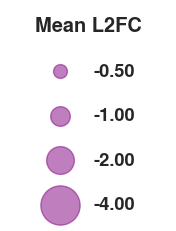

In [19]:
make_size_legend(sizes=[0.5, 1.0, 2.0, 4.0])


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join

def make_hit_corr(cell1='K562', cell2='Jurkat', label=None, library=None, editor=None, baseline=None, endpoint=None,
                  highlight_groups=None, highlight_colors=None, annotate=True,
                  input_path='../restore/data/output/DESeq', output_path='./Figures/hits',
                  cap=-12, use_squashed_scale=False):
    
    if cell1 == cell2:
        df_cell1 = pd.read_csv(join(input_path, f'DESeq2_{cell1}_{library}_{editor}_D14_DN1.csv'), index_col=0)
        df_cell2 = pd.read_csv(join(input_path, f'DESeq2_{cell2}_{library}_{editor}_D0_DN1.csv'), index_col=0)
        column_name = ['D26 Adjusted P-value', 'D12 Adjusted P-value', 'D26_LFC', 'D12_LFC']
    else:
        df_cell1 = pd.read_csv(join(input_path, f'DESeq2_{cell1}_{library}_{editor}_{endpoint}_{baseline}.csv'), index_col=0)
        df_cell2 = pd.read_csv(join(input_path, f'DESeq2_{cell2}_{library}_{editor}_{endpoint}_{baseline}.csv'), index_col=0)
        column_name = [cell1+' Adjusted P-value', cell2+' Adjusted P-value', cell1+'_LFC', cell2+'_LFC']
        
    abbv1 = cell1[0] + library[0]
    abbv2 = cell2[0] + library[0]

    # Apply transformation to adjusted p-values
    def transform_pval(pval):
        pval_log = np.log10(pval)
        if use_squashed_scale:
            return np.arcsinh(pval_log)  # Squashed scale
        else:
            return np.maximum(pval_log, cap)  # Min log transformation with capping

    df_lfc = pd.concat([
        df_cell1['padj'].apply(transform_pval),
        df_cell2['padj'].apply(transform_pval),
        df_cell1['log2FoldChange']**2,
        df_cell2['log2FoldChange']**2
    ], axis=1)
    
    df_lfc.columns = column_name
    
    list_label = [i for i in df_lfc.index if i.startswith(label)]
    df_lfc = df_lfc.loc[list_label, :]
    
    corr = df_lfc[column_name[0]].corr(df_lfc[column_name[1]])
    df_lfc = df_lfc.dropna(subset=[column_name[0], column_name[1], column_name[2], column_name[3]])
    s_values = df_lfc[[column_name[2], column_name[3]]].mean(axis=1).fillna(0).values * 200  # Fill NaN with 0 to avoid errors

    # Create plot
    fig, ax = plt.subplots(figsize=(5, 5))
    
    scatter = sns.scatterplot(data=df_lfc, x=column_name[0], y=column_name[1], alpha=0.5, ax=ax,
                              s=s_values, color='purple', label=f'Other sgRNAs (n={len(df_lfc)})')
    sns.rugplot(data=df_lfc, x=column_name[0], ax=ax, height=0.05,  alpha=0.3)

    if highlight_groups:
        df_lfc_highlight = df_lfc.loc[highlight_groups, :]
        print(df_lfc_highlight)
        sns.scatterplot(data=df_lfc_highlight, x=column_name[0], y=column_name[1], alpha=0.5, ax=ax,
                        s=df_lfc_highlight[[column_name[2], column_name[3]]].mean(axis=1).values * 200,
                        edgecolor='white', linewidth=2, color="red", label=f'Candidate (n={len(df_lfc_highlight)})')
        sns.rugplot(data=df_lfc_highlight, x=column_name[0], ax=ax, height=0.05, color="red", alpha=0.8)

    ax.set_xlim(cap-0.5, 0.5)
    ax.set_ylim(cap-0.5, 0.5)
    ax.set_xlabel('log10 ' + column_name[0], fontweight='bold')
    ax.set_ylabel('log10 ' + column_name[1], fontweight='bold')
    
    title_label = 'Synonymous' if label == 'SYN' else 'Missense'
    
    if use_squashed_scale:
        ax.set_title(f'{library} {title_label} (Squashed Scale)', fontweight='bold')
    else:
        ax.set_title(f'{library} {title_label} (Min-log Capped at {cap})', fontweight='bold')

    ax.axhline(transform_pval(0.05), ls='--', color='gray', alpha=0.5)
    ax.axvline(transform_pval(0.05), ls='--', color='gray', alpha=0.5)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.plot([0, cap], [0, cap], ls='--', color='gray', alpha=0.5)  # Diagonal reference line
    ax.set_aspect('equal')

    # Add legend

    ax.legend(loc='upper left', bbox_to_anchor=(0.45, 0.25), fontsize=10,frameon = False)
    for legend_handle in ax.legend_.legendHandles:
        legend_handle.set_sizes([80])  # Adjust the size as needed


    # Adjust layout
    plt.tight_layout()
    
    # Save and display
    output_file = join(output_path, f'corr_{cell1}_{cell2}_{label}_{library}_{editor}_{baseline}_{endpoint}.png')
    plt.savefig(output_file, transparent=True, dpi=800)


                  D26 Adjusted P-value  D12 Adjusted P-value   D26_LFC  \
SYN_DYNC1H1_1108             -2.492302             -1.545526  1.259027   
SYN_PSMB5_1536               -2.820524             -1.489403  4.390175   
SYN_VCP_467                  -2.073862             -1.489108  0.951136   
SYN_SF3B3_2907               -6.061463             -3.927948  4.538251   

                   D12_LFC  
SYN_DYNC1H1_1108  0.418791  
SYN_PSMB5_1536    1.216881  
SYN_VCP_467       0.282006  
SYN_SF3B3_2907    1.279190  


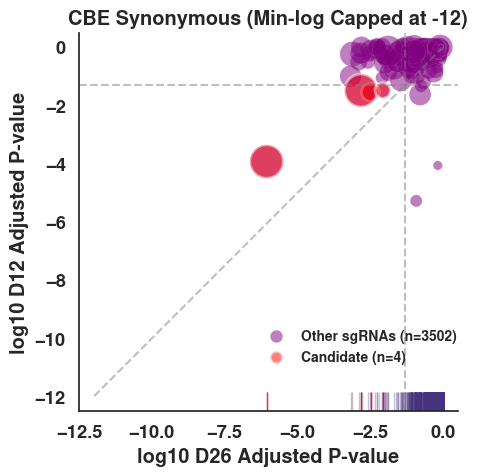

In [7]:
highlight_candidate = pickle.load(open('./processed/CBE_SYN_Candidates.pkl', 'rb'))

make_hit_corr(cell1 = 'K562', cell2 = 'K562',label = 'SYN', 
                 library = 'CBE', editor = 'CBE', 
                 baseline = 'DN1', endpoint = 'D14',
              highlight_groups = highlight_candidate,
              highlight_colors = 'red',
                annotate = False)

                  K562 Adjusted P-value  Jurkat Adjusted P-value  K562_LFC  \
MIS_RPAP1_10984               -1.769644                -4.026208  3.076185   
MIS_COPA_5845                 -3.148620                -7.207288  3.253816   
MIS_RPAP1_11195              -12.000000               -12.000000  9.550023   
MIS_POLR2B_12064              -3.415730                -7.949075  1.222458   
MIS_CDC16_7200                -4.721377                -1.953069  5.207843   
MIS_POLR2C_11387              -3.301006                -6.093902  4.821227   
MIS_ECD_14808                -10.363278               -12.000000  6.147448   
MIS_POLR1A_2208               -9.746132                -9.102245  3.097499   
MIS_ECD_14812                 -2.826904                -2.707494  5.705152   

                  Jurkat_LFC  
MIS_RPAP1_10984     5.518845  
MIS_COPA_5845       5.187470  
MIS_RPAP1_11195    15.428585  
MIS_POLR2B_12064    2.290729  
MIS_CDC16_7200      1.596208  
MIS_POLR2C_11387   10.117430  
MI

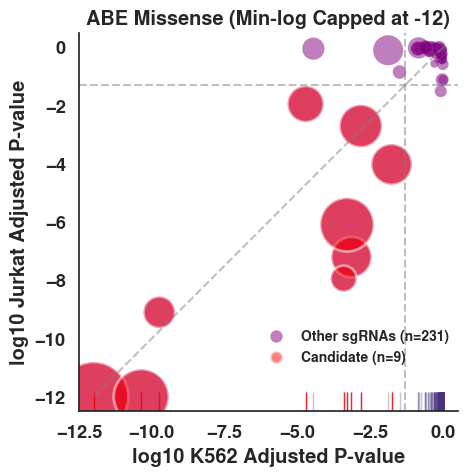

In [11]:
highlight_candidate = pickle.load(open('./processed/ABE_MIS_Candidates.pkl', 'rb'))

make_hit_corr(cell1 = 'K562', cell2 = 'Jurkat',label = 'MIS', 
                 library = 'ABE', editor = 'ABE', 
                 baseline = 'DN1', endpoint = 'D0',
              highlight_groups = highlight_candidate,
              highlight_colors = ['red'],
                annotate = False)

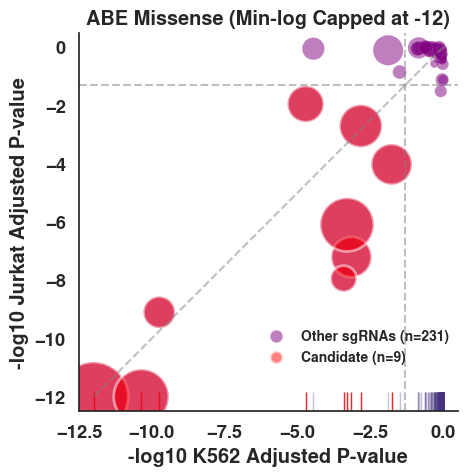

In [51]:
highlight_candidate = pickle.load(open('./processed/ABE_MIS_Candidates.pkl', 'rb'))

make_hit_corr(cell1 = 'K562', cell2 = 'Jurkat',label = 'MIS', 
                 library = 'ABE', editor = 'ABE', 
                 baseline = 'DN1', endpoint = 'D0',
              highlight_groups = highlight_candidate,
              highlight_colors = ['red'],
                annotate = False)

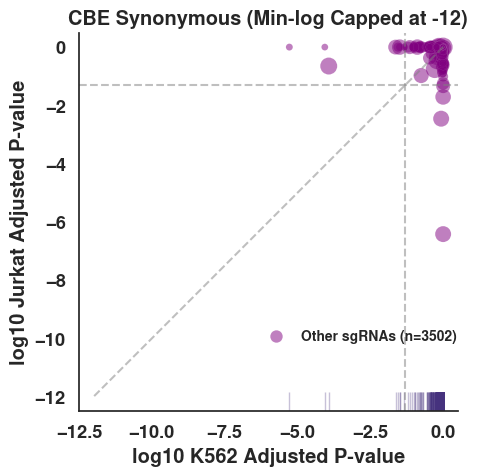

In [9]:
make_hit_corr(cell1 = 'K562', cell2 = 'Jurkat',label = 'SYN', 
                 library = 'CBE', editor = 'CBE', 
                 baseline = 'DN1', endpoint = 'D0',
              highlight_groups = None,
              highlight_colors = None,
                annotate = False)

                 K562 Adjusted P-value  Jurkat Adjusted P-value  K562_LFC  \
SYN_DYNC1H1_581              -2.204832                -4.656738  2.967180   
SYN_RUVBL1_1802              -2.254942                -1.594406  2.207329   
SYN_SFPQ_64                 -12.000000                -3.035571  3.020661   
SYN_HSPA9_1786               -5.741916                -1.382115  3.037766   

                 Jurkat_LFC  
SYN_DYNC1H1_581    2.993670  
SYN_RUVBL1_1802    1.047740  
SYN_SFPQ_64        0.531216  
SYN_HSPA9_1786     0.495304  


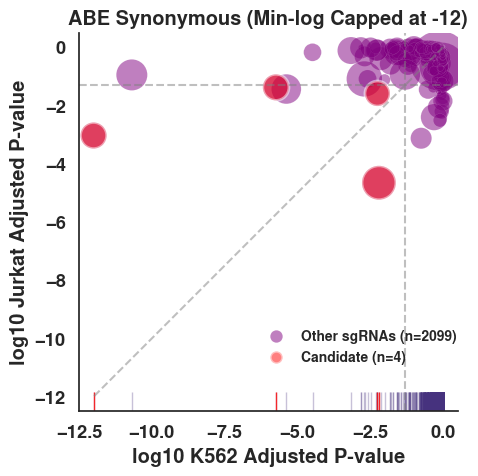

In [10]:
highlight_candidate = pickle.load(open('./processed/ABE_SYN_Candidates.pkl', 'rb'))

make_hit_corr(cell1 = 'K562', cell2 = 'Jurkat',label = 'SYN', 
                 library = 'ABE', editor = 'ABE', 
                 baseline = 'DN1', endpoint = 'D0',
              highlight_groups = highlight_candidate,
              highlight_colors = ['red'],
                annotate = False)

### 7. Heatmap

In [54]:
# For synonymous and non-synonymous mutations, synonymous sgRNA - D17 Edited alleles relative to D5, D17 GFP% relative to D5
# Synonymous ABE : A1 - A4 ; Synonymous CBE : C1-C2
# Missense ABE: E1 - E8; missense CBE: F1 -F8

df_syn = pd.read_csv('./processed/hit_heatmap_syn.csv')
df_nsyn = pd.read_csv('./processed/hit_heatmap_mis.csv')

output_path='./Figures/hits'
sns.set_theme(style="white", font_scale=1.5,palette='viridis')
font = {'weight' : 'bold', 'family':'Nimbus Sans'}
rc('font', **font) 

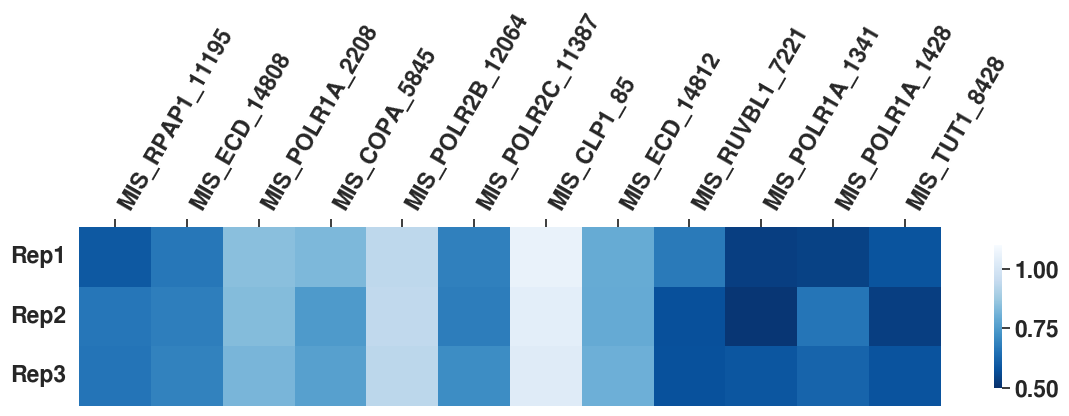

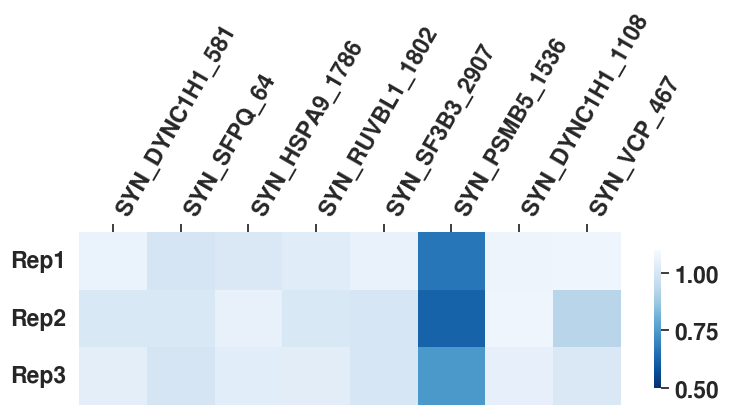

In [55]:
# Define the number of sgRNAs for each dataset
num_sgRNA_nsyn = len(df_nsyn["sgRNA"])
num_sgRNA_syn = len(df_syn["sgRNA"])

# Define a fixed square size per sgRNA
square_size = 1  # Adjust if needed

fig_height_nsyn = num_sgRNA_nsyn * square_size
fig_height_syn = num_sgRNA_syn * square_size

fig, ax = plt.subplots(1, 1, figsize=(fig_height_nsyn,4.5))
sns.heatmap(df_nsyn[['sgRNA', 'Rep1', 'Rep2', 'Rep3']].set_index('sgRNA').T, 
            cmap="Blues_r", cbar=True, vmin=0.5, vmax=1.1, cbar_kws={'shrink': 0.8},
            square=False)  # Ensure non-square scaling
ax.xaxis.set_label_position('top'); ax.xaxis.tick_top()
ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha="left")
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha="right")
ax.set_ylabel('')
ax.set_xlabel('')
plt.tight_layout()

output_file = join(output_path, f'heatmap_nsyn.png')
plt.savefig(output_file, transparent=True)

fig, ax = plt.subplots(1, 1, figsize=(fig_height_syn,4.5))
sns.heatmap(df_syn[['sgRNA', 'Rep1', 'Rep2', 'Rep3']].set_index('sgRNA').T, 
            cmap="Blues_r", cbar=True, vmin=0.5, vmax=1.1, cbar_kws={'shrink': 0.8},
            square=False)  # Ensure non-square scaling
ax.xaxis.set_label_position('top'); ax.xaxis.tick_top()
ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha="left")
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha="right")
ax.set_ylabel('')
ax.set_xlabel('')
plt.tight_layout()

output_file = join(output_path, f'heatmap_syn.png')
plt.savefig(output_file, transparent=True)

In [ ]:
sn